## Практична робота №1 (частина 1)
**Виконав**
**студент групи ФІ-32мн**
**Кріпака Ілля**

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import transpile
from qiskit.providers.basic_provider import BasicSimulator

У даній практичній реалізовано алгоритм додавання за схемою **Ripple adder**
[link](https://arxiv.org/pdf/quant-ph/0410184)

Гловна ідея алгоритму, це використання функції MAJ для обчислення бітів переносу для кожного додавання та потім функції UMA (UnMajority and Add).
Тобто перша функція обчислює біти переносу, а інша їх можна сказати "знищує" та робить фінальне додавання.

MAJ має наступний вигляд:

![MAJ gate](./data/maj.png)

UMA має наступний вигляд:

![UMA gate](./data/uma.png)

Варто додати, що у загальному ці кампоненти працюють наступним чином: 

![Gates combined](./data/gates_combined.png)

Тобто, виходить, що місцем зняття фінальної інформації про додавання буде зніматися із регістрів **b_i** та останнього регістру із бітом переносу **z**(можна сказати, що це **s_n**). Вентиль UMA має 2 варіанти реалізації, але у практичній роботі реалізовано лише перший варіант із двома CNOT гейтами. 

In [2]:
def fill_register(qc: QuantumCircuit, a: QuantumRegister, num, n):
    for i in range(n):
        if (num >> i) & 1 == 1:
            qc.x(a[i])


def majority(p, a, b, c):
    """Majority gate."""
    p.cx(c, b)
    p.cx(c, a)
    p.ccx(a, b, c)


def unmajority(p, a, b, c):
    """Unmajority gate."""
    p.ccx(a, b, c)
    p.cx(c, a)
    p.cx(a, b)

{'00010': 1024}


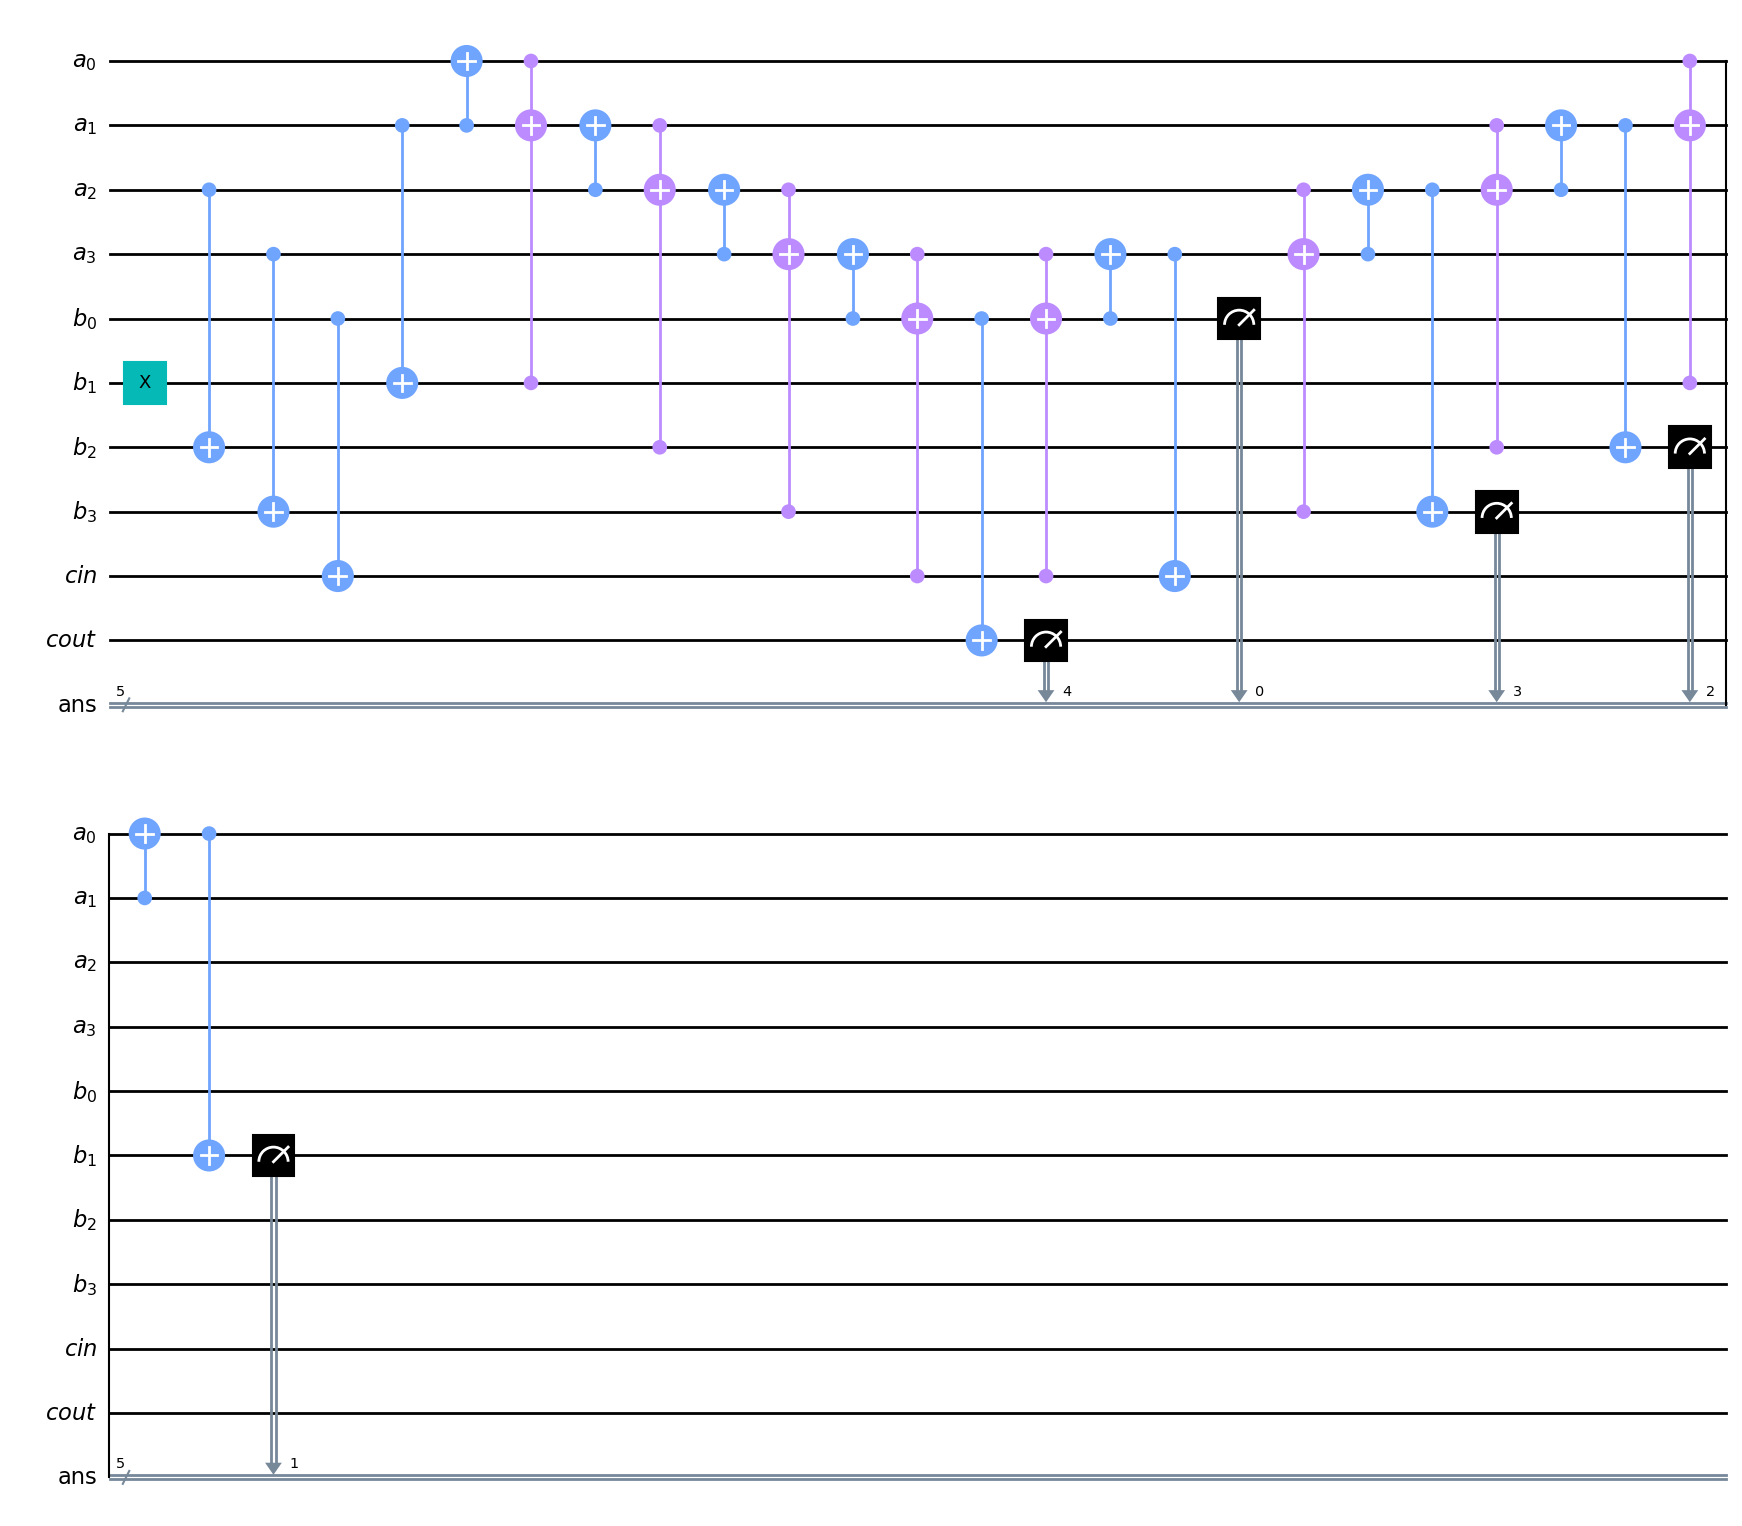

In [3]:
A = 0b0000
B = 0b0010
# Number of bits to be added
n = 4

backend = BasicSimulator()
a = QuantumRegister(n, "a")
b = QuantumRegister(n, "b")
cin = QuantumRegister(1, "cin")
cout = QuantumRegister(1, "cout")
ans = ClassicalRegister(n + 1, "ans")
qc = QuantumCircuit(a, b, cin, cout, ans, name="rippleadd")

# Build a temporary subcircuit that adds a to b,
adder_subcircuit = QuantumCircuit(cin, a, b, cout)
majority(adder_subcircuit, cin[0], b[0], a[0])
for j in range(n - 1):
    majority(adder_subcircuit, a[j], b[j + 1], a[j + 1])
adder_subcircuit.cx(a[n - 1], cout[0])
for j in reversed(range(n - 1)):
    unmajority(adder_subcircuit, a[j], b[j + 1], a[j + 1])
unmajority(adder_subcircuit, cin[0], b[0], a[0])

# Fill inputs
fill_register(qc, a, A, n)
fill_register(qc, b, B, n)

# Add numbers
qc &= adder_subcircuit
# Measure the output register in the computational basis
for j in range(n):
    qc.measure(b[j], ans[j])
qc.measure(cout[0], ans[n])

# Measure output with shots
job = backend.run(transpile(qc, backend=backend, coupling_map=None), shots=1024)
result = job.result()
print(result.get_counts(qc))

qc.draw(output="mpl", style="clifford")

Вектори на яких додавання виконується:
* правильно
    * A=0b0001 B=0b1111
    * A=0b0100 B=0b0100
    * A=0b0100 B=0b1000
    * A=0b0100 B=0b0011
    * і інші подібні варіації
* неправильно
    * A=0b1000 B=0b1100 = 0b00100
    * A=0b0100 B=0b1100 = 0b00000
    * A=0b1000 B=0b1000 = 0b00000
    * A=0b0001 B=0b0001 = 0b00011
    * A=0b0001 B=0b0011 = 0b00101
    * A=0b0011 B=0b0011 = 0b00111
    * A=0b0001 B=0b1000 = 0b01010
    * і інші подібні комбінації

у підсумку можна скзати, що ідея використання Ripple Adder цікава, але має нюанси у обчисленні.